先使用vgg16的卷积基，然后添加自己的密集分类层   
首先是数据划分，打乱顺序和重命名之后按照3：1：1的比例分成train、validaiton、test三个文件夹  
keras会自己根据文件夹发现有多少个类别，并自动执行多元交叉验证  

## 主要步骤
> 1.加载VGG16模型（不包含密集连接层，因为我们要用自己的四分类）  
> 2.打乱源文件并按上述比例分配好供keras使用  
> 3.根据VGG16模型的最后输出写自己的四分类密集连接分类器  
> 4.将VGG16模型冻结，用自己的数据训练密集分类器  
> 5.画出训练精度验证精度和训练损失验证损失

In [ ]:
from keras import models 
from keras import layers 
from keras.applications import VGG16 

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 

In [ ]:
# 将原文件夹下的图片重新命名
import os 
import shutil 
import random 

def rename(path):
    file_list = os.listdir(path) 
    file_num = len(file_list) 
    random_num = random.sample(range(0,file_num), file_num)  # 生成(0,file_num)范围内file_num个不重复的随机数
    
    i = 0 
    for files in file_list:
        old_dir_path = os.path.join(path, files) 

        file_name = os.path.splitext(files)[0] 
        file_type = os.path.splitext(files)[1] 
        
        new_dir_path = os.path.join(path, str(random_num[i]) + file_type)
        os.rename(old_dir_path, new_dir_path) 
        i += 1

path = r'D:\BaiduNetdiskDownload\DLdata\garbage_classify_demo' 

rename(path+'\\0')
rename(path+'\\1')
rename(path+'\\2')
rename(path+'\\3') 

In [ ]:
# 数据预处理，将源文件夹下的0123四个文件夹下的图片，分成train、validation、test

# 创建文件夹结构
original_dataset_dir = r'D:\BaiduNetdiskDownload\DLdata\garbage_classify_demo' 
base_dir = r'D:\BaiduNetdiskDownload\DLdata\garbage_classify'
shutil.rmtree(base_dir) 
os.mkdir(base_dir) 

train_dir = os.path.join(base_dir, 'train') 
os.mkdir(train_dir) 
validation_dir = os.path.join(base_dir, 'validation') 
os.mkdir(validation_dir) 
test_dir = os.path.join(base_dir, 'test') 
os.mkdir(test_dir) 


# 统计每个种类垃圾的图片文件个数，打乱文件，之后按照train:validation:test == 3:1:1的比例分别放到对应文件夹
dir_path = ['0', '1', '2', '3'] 
number_of_file = [0, 0, 0, 0]
numbers = []
for path in dir_path:
    files = os.listdir(os.path.join(original_dataset_dir, path)) 
    num_img = len(files) 
    number_of_file[int(path)] = num_img 
    temp = num_img // 5
    numbers.append([0, 3*temp, 4*temp, 5*temp])


dst_dirs = [train_dir, validation_dir, test_dir] 

for i in range(3):
    dir = dst_dirs[i]
    for j in range(len(numbers)):
        num = numbers[j]
        temp_dir = os.path.join(dir, str(j)) 
        os.mkdir(temp_dir) 
        for k in range(num[i], num[i+1]):
            src = os.path.join(original_dataset_dir+'\\'+str(j), str(k)+'.jpg')
            dst = os.path.join(temp_dir, str(k)+'.jpg')
            shutil.copyfile(src, dst)



In [40]:
# 使用预训练的卷积基提取特征
import os 
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'D:\BaiduNetdiskDownload\DLdata\garbage_classify'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test') 

datagen = ImageDataGenerator(rescale=1./255)  # 缩放比率为1/255
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # (4,4,512)是VGG16模型的最后输出
    labels = np.zeros(shape=(sample_count, 4)) 
    generator = datagen.flow_from_directory( 
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='categorical' 
    )
    i = 0 
    for inputs_batch, labels_batch in generator: 
        features_batch = conv_base.predict(inputs_batch) 
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if (i+1)*batch_size >= sample_count:
            break 
    return features, labels 

train_features, train_labels = extract_features(train_dir, 2061) 
validation_features, validation_labels = extract_features(validation_dir, 687) 
test_features, test_labels = extract_features(test_dir, 687) 

# 目前提取的特征形状为(samples,4,4,512)，要将其输入到密集连接分类器中，必须先展平为(samples, 8192)
train_features = np.reshape(train_features, (train_features.shape[0], 4 * 4 * 512)) 
validation_features = np.reshape(validation_features, (validation_features.shape[0], 4 * 4 * 512)) 
test_features = np.reshape(test_features, (test_features.shape[0], 4 * 4 * 512)) 


Found 2061 images belonging to 4 classes.
Found 687 images belonging to 4 classes.
Found 687 images belonging to 4 classes.


In [53]:
# 定义并训练密集连接分类器
from keras import optimizers

model = models.Sequential() 
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512)) 
# model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(4, activation='softmax'))  # 对应四种垃圾：有害(电池)、可回收、厨余(湿)、其他(干垃圾吧)

# 冻结卷积基，如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改
conv_base.trainable = False 

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

model.compile(
    optimizers.RMSprop(lr=2e-5), 
    loss='categorical_crossentropy', 
    metrics=['acc']
)

history = model.fit(
    train_features, 
    train_labels, 
    epochs=20,  # 设定的是100轮，但根据交叉验证损失图得：20轮时是最佳的，再往后validation loss会逐渐变大
    batch_size=20, 
    validation_data = (validation_features, validation_labels)
)

model.save('output/initial_version.h5')


Epoch 1/20
104/104 [==============================] - 4s 32ms/step - loss: 1.3698 - acc: 0.4113 - val_loss: 0.7635 - val_acc: 0.7089
Epoch 2/20
104/104 [==============================] - 3s 33ms/step - loss: 0.8240 - acc: 0.6628 - val_loss: 0.6142 - val_acc: 0.7656
Epoch 3/20
104/104 [==============================] - 3s 27ms/step - loss: 0.6432 - acc: 0.7513 - val_loss: 0.5390 - val_acc: 0.8253
Epoch 4/20
104/104 [==============================] - 3s 31ms/step - loss: 0.5443 - acc: 0.7921 - val_loss: 0.4829 - val_acc: 0.8311
Epoch 5/20
104/104 [==============================] - 3s 31ms/step - loss: 0.5057 - acc: 0.8184 - val_loss: 0.4566 - val_acc: 0.8268
Epoch 6/20
104/104 [==============================] - 3s 27ms/step - loss: 0.4563 - acc: 0.8447 - val_loss: 0.4356 - val_acc: 0.8384
Epoch 7/20
104/104 [==============================] - 3s 28ms/step - loss: 0.4039 - acc: 0.8563 - val_loss: 0.4073 - val_acc: 0.8675
Epoch 8/20
104/104 [==============================] - 4s 35ms/step - 

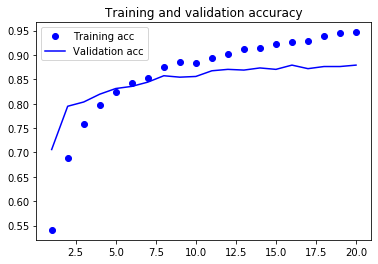

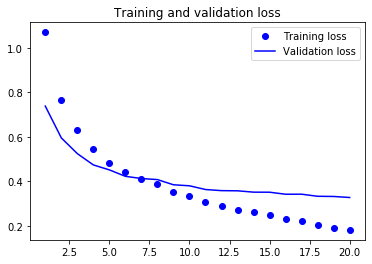

In [52]:
# 绘制结果
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show() 

## 接下来使用数据增强来训练模型


In [55]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,       # 图像随机旋转0~40度（最大80度）
    width_shift_range=0.2,   # 水平方向上平移
    height_shift_range=0.2,  # 垂直方向上平移
    shear_range=0.2,         # 随机错切变换的角度
    zoom_range=0.2,          # 图像随机缩放的范围
    horizontal_flip=True,    # 随机将一半图像水平翻转
    fill_mode='nearest'      # 用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度/高度平移
)
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)

history = model.fit_generator(  
    # 这里有时候会报错，把几个epoch调低点就可以了，我也不懂为啥，尽量不要与原来的差太多
    train_generator, 
    steps_per_epoch=50, 
    epochs=100, 
    validation_data=validation_generator, 
    validation_steps=10
)

# 保存模型
# model.save('cats_and_dogs_small_2.h5') 


Found 2061 images belonging to 4 classes.
Found 687 images belonging to 4 classes.
Epoch 1/100


ValueError: in user code:

    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    D:\code\environment\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None) and (None, None, None, 4) are incompatible


In [ ]:
# 绘制新的训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show() 